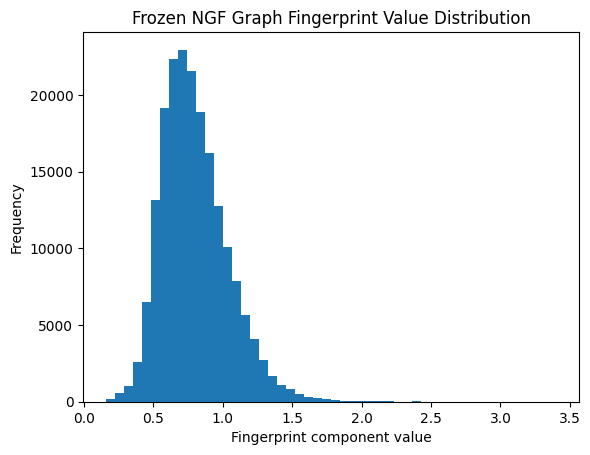

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import NeuralFingerprint
from data import BACE_GNN

dataset = BACE_GNN(root='data/BACE_GNN')
loader = DataLoader(dataset, batch_size=64, shuffle=False)

ngf = NeuralFingerprint(
    in_channels=dataset.num_node_features,
    hidden_channels=64,
    out_channels=128,
    num_layers=3
)
for param in ngf.parameters():
    param.requires_grad = False
ngf.eval()

# Collect embeddings
embeddings = []
with torch.no_grad():
    for batch in loader:
        batch = batch.to('cpu')
        emb = ngf(batch.x.float(), batch.edge_index, batch.batch)
        embeddings.append(emb)
all_emb = torch.cat(embeddings, dim=0)  

vals = all_emb.flatten().numpy()


# Plot distribution
plt.figure()
plt.hist(vals, bins=50)
plt.title("Frozen NGF Graph Fingerprint Value Distribution")
plt.xlabel("Fingerprint component value")
plt.ylabel("Frequency")
plt.show()


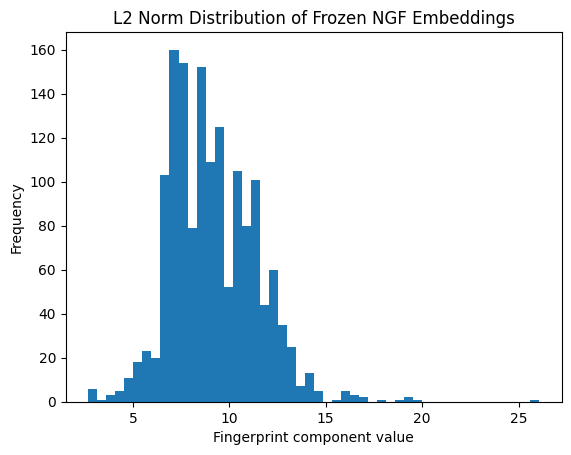

In [ ]:
norms = torch.norm(all_emb, dim=1).numpy()

# distribution
plt.figure()
plt.hist(norms, bins=50)
plt.title("L2 Norm Distribution of Frozen NGF Embeddings")
plt.xlabel("Fingerprint component value")
plt.ylabel("Frequency")
plt.show()


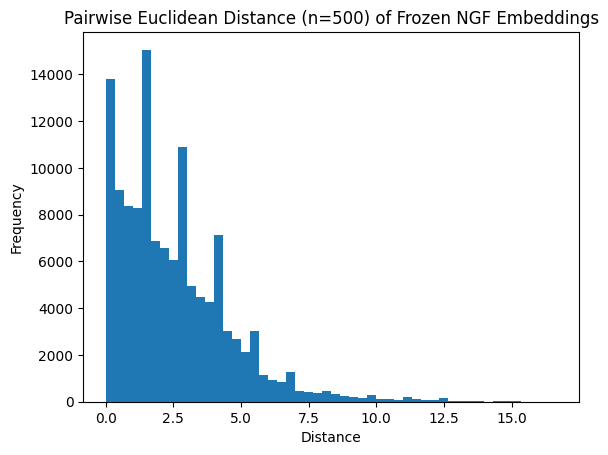

In [ ]:
# Sample 500 embeddings
N = all_emb.size(0)
idx = torch.randperm(N)[:500]
sampled = all_emb[idx]  # [500, 128]

# Compute pairwise distances streaming
dists = []
for i in range(500):
    vec = sampled[i].unsqueeze(0)     
    rest = sampled[i+1:]                
    dist = torch.norm(vec - rest, dim=1) 
    dists.append(dist)
dists = torch.cat(dists).cpu().numpy()  

# Plot histogram
plt.figure()
plt.hist(dists, bins=50)
plt.title("Pairwise Euclidean Distance (n=500) of Frozen NGF Embeddings")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()


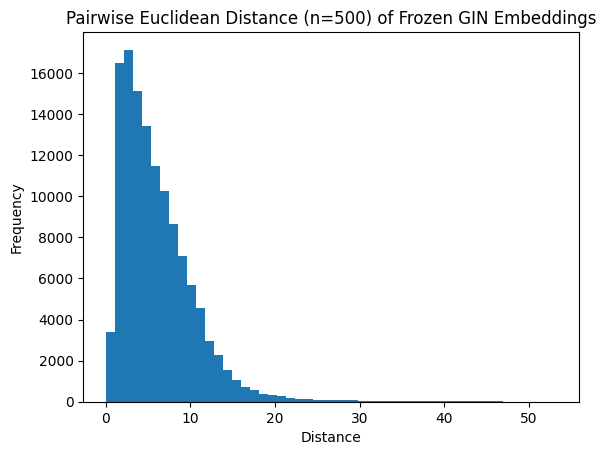

In [ ]:
import torch
import matplotlib.pyplot as plt
from models import MultiLayerGIN
from torch_geometric.loader import DataLoader
from data import BACE_GNN

dataset = BACE_GNN(root='data/BACE_GNN')
loader  = DataLoader(dataset, batch_size=64, shuffle=False)

gin = MultiLayerGIN(
    in_channels=dataset.num_node_features,
    hidden_channels=64,
    num_layers=3
)
for p in gin.parameters(): p.requires_grad = False
gin.eval()

all_emb = []
with torch.no_grad():
    for batch in loader:
        batch = batch.to('cpu')
        emb = gin(batch)
        all_emb.append(emb)
all_emb = torch.cat(all_emb, dim=0) 

N = all_emb.size(0)
idx = torch.randperm(N)[:500]
sampled = all_emb[idx] 

dists = []
for i in range(500):
    vec = sampled[i].unsqueeze(0)      
    rest = sampled[i+1:]               
    dist = torch.norm(vec - rest, dim=1) 
    dists.append(dist)
dists = torch.cat(dists).cpu().numpy() 


plt.figure()
plt.hist(dists, bins=50)
plt.title("Pairwise Euclidean Distance (n=500) of Frozen GIN Embeddings")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()


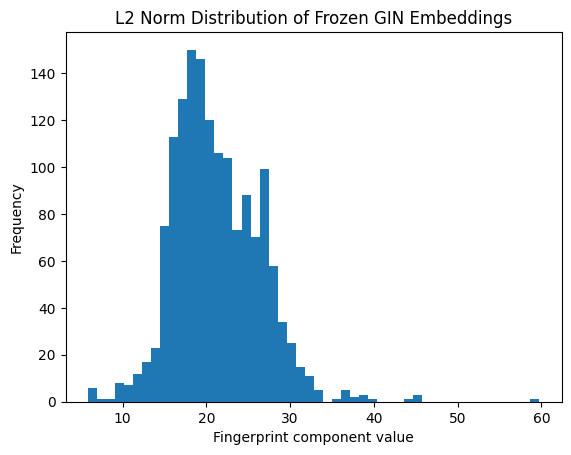

In [ ]:
norms = torch.norm(all_emb, dim=1).numpy()

plt.figure()
plt.hist(norms, bins=50)
plt.title("L2 Norm Distribution of Frozen GIN Embeddings")
plt.xlabel("Fingerprint component value")
plt.ylabel("Frequency")
plt.show()

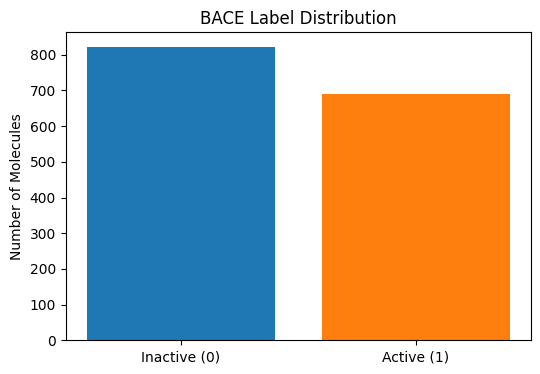

Ratio of inactive molecules: 0.543291473892928


In [ ]:
import matplotlib.pyplot as plt
from torch_geometric.datasets import MoleculeNet

dataset = MoleculeNet(root='data/MoleculeNet', name='bace')

labels = [data.y.item() for data in dataset]  

counts = {
    0: labels.count(0),
    1: labels.count(1),
}

plt.figure(figsize=(6,4))
plt.bar(['Inactive (0)', 'Active (1)'], [counts[0], counts[1]], color=['C0','C1'])
plt.title("BACE Label Distribution")
plt.ylabel("Number of Molecules")
plt.show()

print("Ratio of inactive molecules:", counts[0]/(counts[0]+counts[1]))
